In [36]:
### General imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import matplotlib

import arviz as az

### --- Figure config
LEGEND_SIZE = 15

# az.style.use("arviz-darkgrid")
plt.style.use('dark_background')

matplotlib.rcParams.update(
    {"font.size": 16, "font.family" : "serif", "axes.labelsize": 24, "axes.titlesize": 18, "text.usetex": True,
    "xtick.major.width": 1.5, "xtick.minor.width": 1.2, "ytick.major.width": 1.5, "ytick.minor.width": 1.2,
    "legend.fontsize": 18}
)

%matplotlib inline

In [2]:
from emukit.test_functions import forrester_function
from emukit.core.loop.user_function import UserFunctionWrapper
from emukit.core import ContinuousParameter, ParameterSpace

target_function, space = forrester_function()

In [6]:
x_plot = np.linspace(space.parameters[0].min, space.parameters[0].max, 200)[:, None]
y_plot = target_function(x_plot)

# init design
X_init = np.array([[0.2], [0.6], [0.9]])
Y_init = target_function(X_init)

In [4]:
# the model
import GPy
from emukit.model_wrappers.gpy_model_wrappers import GPyModelWrapper

(0.0, 1.0)

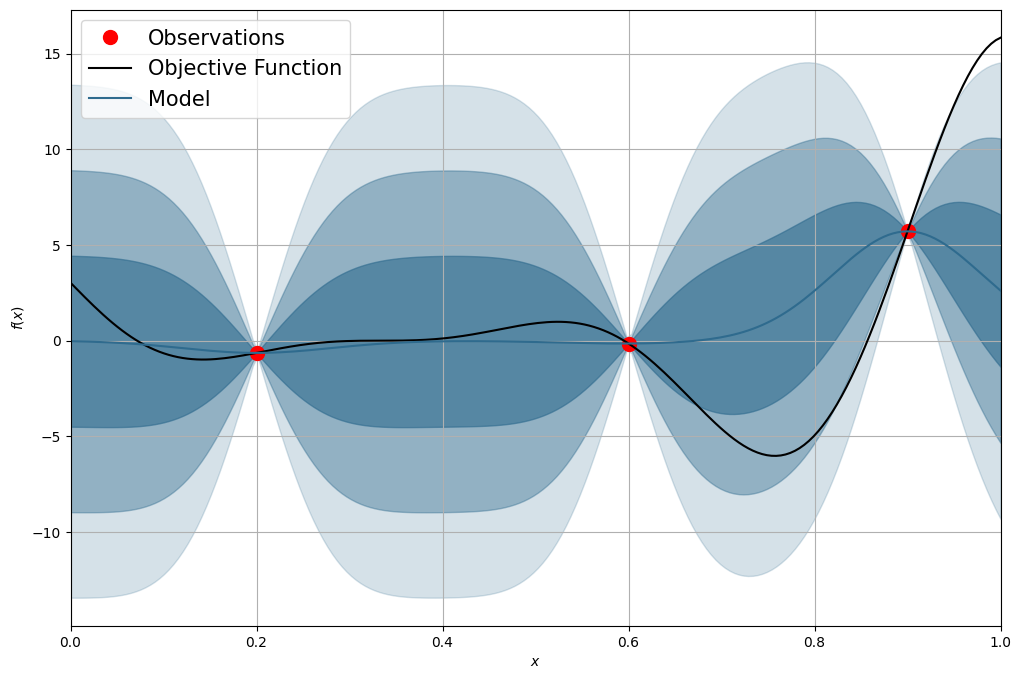

In [9]:
gpy_model = GPy.models.GPRegression(
    X_init, Y_init, GPy.kern.RBF(1, lengthscale=0.08, variance=20), noise_var=1e-10
)
emukit_model = GPyModelWrapper(gpy_model)

mu_plot, var_plot = emukit_model.predict(x_plot)

plt.figure(figsize=(12, 8))
plt.plot(X_init, Y_init, "ro", markersize=10, label="Observations")
plt.plot(x_plot, y_plot, "k", label="Objective Function")
plt.plot(x_plot, mu_plot, "C1", label="Model")
plt.fill_between(
    x_plot[:, 0],
    mu_plot[:, 0] + np.sqrt(var_plot)[:, 0],
    mu_plot[:, 0] - np.sqrt(var_plot)[:, 0],
    color="C1",
    alpha=0.6,
)
plt.fill_between(
    x_plot[:, 0],
    mu_plot[:, 0] + 2 * np.sqrt(var_plot)[:, 0],
    mu_plot[:, 0] - 2 * np.sqrt(var_plot)[:, 0],
    color="C1",
    alpha=0.4,
)
plt.fill_between(
    x_plot[:, 0],
    mu_plot[:, 0] + 3 * np.sqrt(var_plot)[:, 0],
    mu_plot[:, 0] - 3 * np.sqrt(var_plot)[:, 0],
    color="C1",
    alpha=0.2,
)
plt.legend(loc=2, prop={"size": LEGEND_SIZE})
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.grid(True)
plt.xlim(0, 1)

## Acqucition function


In [12]:
from emukit.bayesian_optimization.acquisitions import (
    ExpectedImprovement,
    NegativeLowerConfidenceBound,
    ProbabilityOfImprovement,
)
from emukit.core.optimization import GradientAcquisitionOptimizer


(0.0, 1.0)

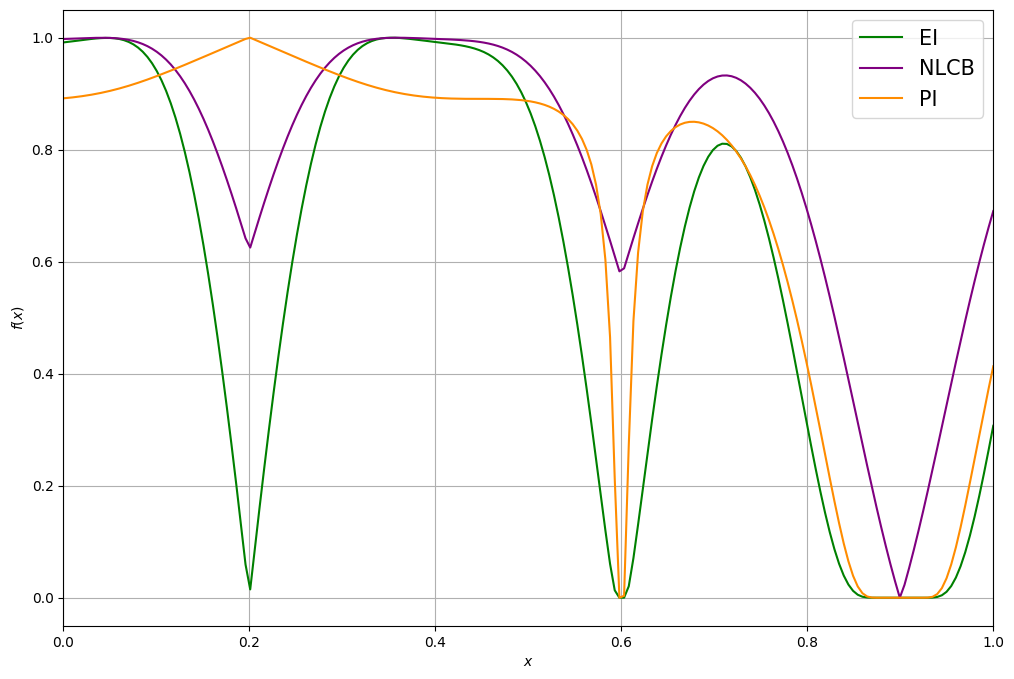

In [11]:
ei_acquisition = ExpectedImprovement(emukit_model)
nlcb_acquisition = NegativeLowerConfidenceBound(emukit_model)
pi_acquisition = ProbabilityOfImprovement(emukit_model)

ei_plot = ei_acquisition.evaluate(x_plot)
nlcb_plot = nlcb_acquisition.evaluate(x_plot)
pi_plot = pi_acquisition.evaluate(x_plot)

plt.figure(figsize=(12, 8))
plt.plot(
    x_plot,
    (ei_plot - np.min(ei_plot)) / (np.max(ei_plot) - np.min(ei_plot)),
    "green",
    label="EI",
)
plt.plot(
    x_plot,
    (nlcb_plot - np.min(nlcb_plot)) / (np.max(nlcb_plot) - np.min(nlcb_plot)),
    "purple",
    label="NLCB",
)
plt.plot(
    x_plot,
    (pi_plot - np.min(pi_plot)) / (np.max(pi_plot) - np.min(pi_plot)),
    "darkorange",
    label="PI",
)

plt.legend(loc=1, prop={"size": LEGEND_SIZE})
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.grid(True)
plt.xlim(0, 1)


In [95]:
# Bayesopt loop
prefix = 8
observation_noise_variance = 5e1
n_iterations = 20

# init design
X_init = np.array(
    [
        [0.1],
    ]
)
Y_init = target_function(X_init)

# define acquisition
gpy_model = GPy.models.GPRegression(
    X_init,
    Y_init,
    GPy.kern.RBF(1, lengthscale=0.08, variance=20),
    noise_var=observation_noise_variance,
)
emukit_model = GPyModelWrapper(gpy_model)

X = X_init
Y = Y_init

for i in range(n_iterations):
    # Get BayesOpt Acquisition Function
    ei_acquisition = ExpectedImprovement(emukit_model)
    # nlcb_acquisition = NegativeLowerConfidenceBound(emukit_model)
    # The 1D Acquisition Function
    ei_plot = ei_acquisition.evaluate(x_plot)

    optimizer = GradientAcquisitionOptimizer(space)

    # BayesOpt provides new point
    x_new, _ = optimizer.optimize(ei_acquisition)
    y_new = target_function(x_new)

    # Plot the next point and acquicition
    fig, ax = plt.subplots(
        2,
        1,
        figsize=(10, 8),
        sharex=True,
        gridspec_kw={
            "height_ratios": [
                2,
                1,
            ]
        },
    )
    ax[1].plot(
        x_plot,
        (ei_plot - np.min(ei_plot)) / (np.max(ei_plot) - np.min(ei_plot)),
        "green",
        label="Expected Improvement",
        # label="Negative Lower Confidence Bound",
    )
    ax[1].vlines(x_new, 0, 1, ls="--")
    ax[1].set_xlabel(r"$x$")
    ax[1].set_ylim(0, 1)
    ax[1].legend(loc="center")

    # Append to data
    X = np.append(X, x_new, axis=0)
    Y = np.append(Y, y_new, axis=0)

    emukit_model.set_data(X, Y)

    mu_plot, var_plot = emukit_model.predict(x_plot)

    ax[0].plot(
        emukit_model.X,
        emukit_model.Y,
        "o",
        color="C3",
        markersize=10,
        label="Observations",
    )
    ax[0].plot(
        x_new,
        y_new,
        marker="*",
        color="C3",
        markersize=20,
    )
    ax[0].plot(x_plot, y_plot, "C7", label="True Function")
    ax[0].plot(x_plot, mu_plot, "C1", label="Surrogate Model")
    ax[0].fill_between(
        x_plot[:, 0],
        mu_plot[:, 0] + np.sqrt(var_plot)[:, 0],
        mu_plot[:, 0] - np.sqrt(var_plot)[:, 0],
        color="C1",
        alpha=0.6,
    )
    ax[0].fill_between(
        x_plot[:, 0],
        mu_plot[:, 0] + 2 * np.sqrt(var_plot)[:, 0],
        mu_plot[:, 0] - 2 * np.sqrt(var_plot)[:, 0],
        color="C1",
        alpha=0.4,
    )
    ax[0].fill_between(
        x_plot[:, 0],
        mu_plot[:, 0] + 3 * np.sqrt(var_plot)[:, 0],
        mu_plot[:, 0] - 3 * np.sqrt(var_plot)[:, 0],
        color="C1",
        alpha=0.2,
    )
    ax[0].legend(loc=2, prop={"size": LEGEND_SIZE})
    ax[0].set_ylabel(r"$f(x)$")
    ax[0].set_xlim(0, 1)
    ax[0].set_ylim(-15.5, 15.5)
    ax[0].set_title(
        "Observation noise variance = {:.2g}".format(observation_noise_variance)
    )

    ax[0].grid(False)
    ax[1].grid(False)

    fig.subplots_adjust(hspace=0, wspace=0)
    fig.patch.set_facecolor("none")

    fig.savefig(
        "../animation/bayes_opt/{}_forrester_{}.png".format(
            str(prefix).zfill(2),
            str(i).zfill(4),
            # str(observation_noise_variance),
        ),
        format="png",
        dpi=150,
    )
    plt.clf()
    plt.close()

 /var/folders/sn/b7hd1bmd569cjwgmtww4mv440000gn/T/ipykernel_80525/2016243524.py:117: UserWarning:This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
